### 1. Load the train and test datasets

In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

parent_directory = os.path.abspath(os.path.join('..'))
grandparent_directory = os.path.abspath(os.path.join(parent_directory, '..'))

sys.path.append(parent_directory)
sys.path.append(grandparent_directory)

# print("Current sys.path:", sys.path)  # To confirm that the path is correctly added
# print("Parent directory:", os.path.abspath(os.path.join('...')))  # To verify the direct

from data_processing_utils.data_processing_functions import load_list_from_txt
train_feather_path = "../../data/train_test_splits/cog_train_family_tax_level.feather"
test_feather_path = "../../data/train_test_splits/cog_test_family_tax_level.feather"
global_vocab_path = "../../data/train_test_splits/global_vocab.txt"

train_df = pd.read_feather(train_feather_path)
val_df = pd.read_feather(test_feather_path)
global_vocab = load_list_from_txt(global_vocab_path)

train_values = train_df.iloc[:, 1:-13].values

sample_names = train_df.iloc[:, 0].values
cog_names = train_df.iloc[:, 1:-13].columns.tolist()
print(f"Number of samples = {len(sample_names)}")
print(f"Number of COGs = {len(cog_names)}")
print(f"Vocabulary size = {len(global_vocab)}")

Number of samples = 90445
Number of COGs = 12873
Vocabulary size = 12873


Epoch 1: Training Loss = 0.1017
Epoch 2: Training Loss = 0.0814
Epoch 3: Training Loss = 0.0761
Epoch 4: Training Loss = 0.0734
Epoch 5: Training Loss = 0.0718
Epoch 6: Training Loss = 0.0705
Epoch 7: Training Loss = 0.0696
Epoch 8: Training Loss = 0.0688
Epoch 9: Training Loss = 0.0682
Epoch 10: Training Loss = 0.0677
Epoch 1: Training Loss = 0.0686
Epoch 2: Training Loss = 0.0682
Epoch 3: Training Loss = 0.0679
Epoch 4: Training Loss = 0.0676
Epoch 5: Training Loss = 0.0673
Epoch 6: Training Loss = 0.0668
Epoch 7: Training Loss = 0.0664
Epoch 8: Training Loss = 0.0659
Epoch 9: Training Loss = 0.0655
Epoch 10: Training Loss = 0.0651
Epoch 1: Training Loss = 0.0692
Epoch 2: Training Loss = 0.0684
Epoch 3: Training Loss = 0.0679
Epoch 4: Training Loss = 0.0676
Epoch 5: Training Loss = 0.0673
Epoch 6: Training Loss = 0.067
Epoch 7: Training Loss = 0.0668
Epoch 8: Training Loss = 0.0665


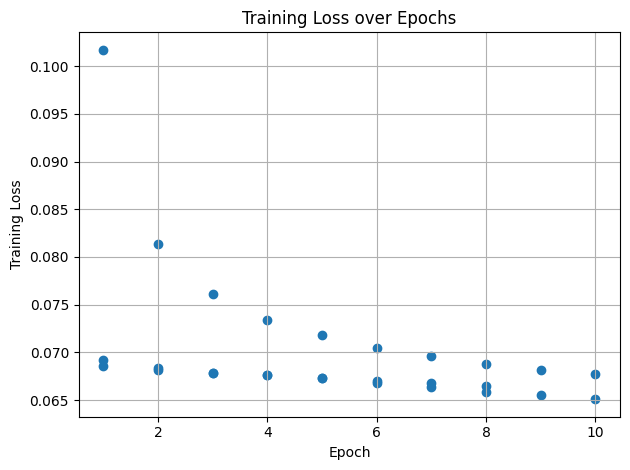

In [ ]:
import re

def extract_training_loss(file_path):
    training_losses = []
    epochs = []

    with open(file_path, 'r') as f:
        for line in f:
            # Match lines with "Epoch [x/y] Training Loss: ..."
            match = re.search(r"Epoch\s+\[(\d+)/\d+\]\s+Training Loss:\s+([\d.]+)", line)
            if match:
                epoch = int(match.group(1))
                loss = float(match.group(2))
                epochs.append(epoch)
                training_losses.append(loss)

    return epochs, training_losses


# Example usage
out_file = "set_transf_embedd_1024_heads_4_sab_2_BCE.out"
epochs, losses = extract_training_loss(out_file)

# Print or plot
for e, l in zip(epochs, losses):
    print(f"Epoch {e}: Training Loss = {l}")    


import matplotlib.pyplot as plt


plt.scatter(epochs, losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.grid(True)
plt.tight_layout()
plt.show()    

In [ ]:
import torch
from post_train_process_utils import target_and_oredict_for_model, compute_metrics, load_model

# Load pre-trained model
embedd_dim = [16, 64, 124, 256, 512, 1024]
heads = [4]
sabs = [2, 4]
st_path_array = [f'full_set_transf_embedd_{d}_heads_4_sab_2_BCE.pth' for d in embedd_dim]

In [ ]:
# Generate the data loader for the train dataset to do the feed forward
from post_train_process_utils import generate_noisy_dataset

batch_size = 10
pad_idx = len(global_vocab) # padding size
train_loader = generate_noisy_dataset(train_df[:500], global_vocab, batch_size, pad_idx, fn_rate=0, fp_rate=0)


In [ ]:
loaded_models_with_predict = {}

for embedd_dim_i in embedd_dim:
    for heads_i in heads:
        for sabs_i in sabs:
            st_path = f'full_set_transf_embedd_{embedd_dim_i}_heads_{heads_i}_sab_{sabs_i}_BCE.pth'

            if os.path.isfile(st_path):

                set_transformer = load_model(st_path, global_vocab, DEVICE, embedd_dim_i, num_heads=heads_i, num_sab=sabs_i) 
                set_transformer.to(DEVICE)
                set_transformer.eval()

                num_params = sum(p.numel() for p in set_transformer.parameters() if p.requires_grad)
                
                X_true, X_predict = target_and_oredict_for_model(train_loader, set_transformer, DEVICE)

                local_dict = {
                    "model": set_transformer,
                    "num_params": num_params,
                    "specs": [embedd_dim_i, heads_i, sabs_i],
                    "X_true": X_true,
                    "X_predict": X_predict
                }

                loaded_models_with_predict[st_path] = local_dict 


Generating Predictions: 100%|██████████| 50/50 [00:07<00:00,  6.26it/s]


In [14]:
loaded_models_with_predict.keys()

dict_keys(['full_set_transf_embedd_16_heads_4_sab_2_BCE.pth', 'full_set_transf_embedd_64_heads_4_sab_2_BCE.pth', 'full_set_transf_embedd_124_heads_4_sab_2_BCE.pth', 'full_set_transf_embedd_256_heads_4_sab_2_BCE.pth', 'full_set_transf_embedd_256_heads_4_sab_4_BCE.pth', 'full_set_transf_embedd_512_heads_4_sab_2_BCE.pth', 'full_set_transf_embedd_1024_heads_4_sab_2_BCE.pth'])

In [15]:
from post_train_process_utils import plot_misclassification_histogram
from post_train_process_utils import accuracy_stats_per_cog_per_sample

#to_plot_distributions_per_sample, to_plot_distributions_per_cog = accuracy_stats_per_cog_per_sample(X_true, X_predict, cog_names)

Overall Metrics: accuracy = 0.95, precision = 0.68, recall = 0.87, f1 = 0.76
specs = [16, 4, 2]
Overall Metrics: accuracy = 0.97, precision = 0.81, recall = 0.87, f1 = 0.84
specs = [64, 4, 2]
Overall Metrics: accuracy = 0.97, precision = 0.84, recall = 0.84, f1 = 0.84
specs = [124, 4, 2]
Overall Metrics: accuracy = 0.97, precision = 0.83, recall = 0.88, f1 = 0.85
specs = [256, 4, 2]
Overall Metrics: accuracy = 0.97, precision = 0.83, recall = 0.88, f1 = 0.85
specs = [256, 4, 4]
Overall Metrics: accuracy = 0.97, precision = 0.81, recall = 0.87, f1 = 0.84
specs = [512, 4, 2]
Overall Metrics: accuracy = 0.97, precision = 0.84, recall = 0.86, f1 = 0.85
specs = [1024, 4, 2]
Overall Metrics: accuracy = 0.95, precision = 0.68, recall = 0.87, f1 = 0.76
Overall Metrics: accuracy = 0.97, precision = 0.81, recall = 0.87, f1 = 0.84
Overall Metrics: accuracy = 0.97, precision = 0.84, recall = 0.84, f1 = 0.84
Overall Metrics: accuracy = 0.97, precision = 0.83, recall = 0.88, f1 = 0.85
Overall Metric

Text(0.5, 0.98, 'Accuracy measures across samples')

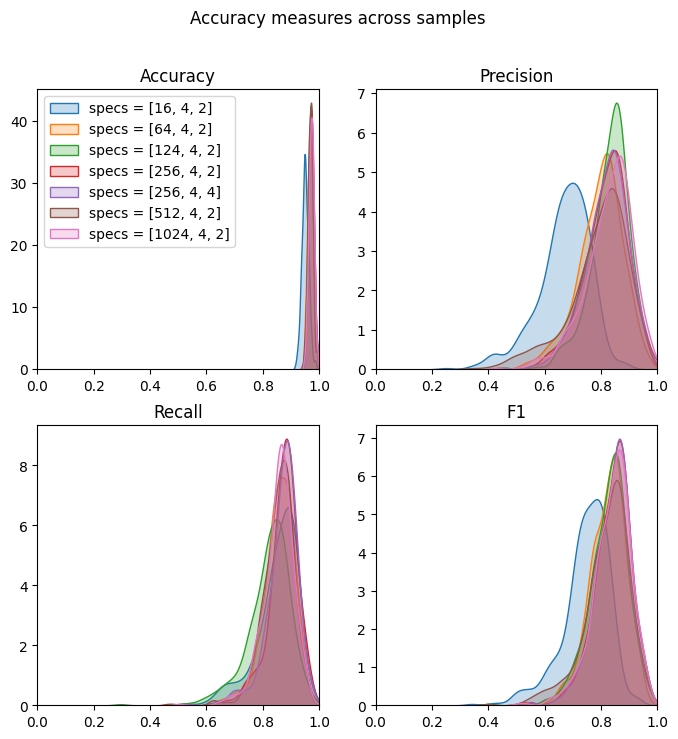

In [18]:
plt.figure(figsize=(8, 8))

# First subplot
plt.subplot(2, 2, 1)
for idx, model_path in enumerate(loaded_models_with_predict.keys()):
    X_true = loaded_models_with_predict[model_path]["X_true"]
    X_predict = loaded_models_with_predict[model_path]["X_predict"]
    to_plot_distributions_per_sample, to_plot_distributions_per_cog = accuracy_stats_per_cog_per_sample(X_true, X_predict, cog_names)
    print(f"specs = {loaded_models_with_predict[model_path]["specs"]}")
    sns.kdeplot(to_plot_distributions_per_sample["accuracy"], fill=True, label = f"specs = {loaded_models_with_predict[model_path]["specs"]}")
plt.xlim([0,1])
plt.ylabel("")
plt.title("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
for idx, model_path in enumerate(loaded_models_with_predict.keys()):
    X_true = loaded_models_with_predict[model_path]["X_true"]
    X_predict = loaded_models_with_predict[model_path]["X_predict"]
    to_plot_distributions_per_sample, to_plot_distributions_per_cog = accuracy_stats_per_cog_per_sample(X_true, X_predict, cog_names)
    sns.kdeplot(to_plot_distributions_per_sample["precision"], fill=True)
plt.title("Precision")
plt.xlim([0,1])
plt.ylabel("")

plt.subplot(2, 2, 3)
for idx, model_path in enumerate(loaded_models_with_predict.keys()):
    X_true = loaded_models_with_predict[model_path]["X_true"]
    X_predict = loaded_models_with_predict[model_path]["X_predict"]
    to_plot_distributions_per_sample, to_plot_distributions_per_cog = accuracy_stats_per_cog_per_sample(X_true, X_predict, cog_names)
    sns.kdeplot(to_plot_distributions_per_sample["recall"], fill=True)
plt.title("Recall")
plt.xlim([0,1])
plt.ylabel("")

plt.subplot(2, 2, 4)
for idx, model_path in enumerate(loaded_models_with_predict.keys()):
    X_true = loaded_models_with_predict[model_path]["X_true"]
    X_predict = loaded_models_with_predict[model_path]["X_predict"]
    to_plot_distributions_per_sample, to_plot_distributions_per_cog = accuracy_stats_per_cog_per_sample(X_true, X_predict, cog_names)
    sns.kdeplot(to_plot_distributions_per_sample["f1"], fill=True)
plt.title("F1")
plt.xlim([0,1])
plt.ylabel("")
plt.suptitle("Accuracy measures across samples")

Overall Metrics: accuracy = 0.95, precision = 0.68, recall = 0.87, f1 = 0.76
Overall Metrics: accuracy = 0.97, precision = 0.81, recall = 0.87, f1 = 0.84
Overall Metrics: accuracy = 0.97, precision = 0.84, recall = 0.84, f1 = 0.84
Overall Metrics: accuracy = 0.97, precision = 0.83, recall = 0.88, f1 = 0.85
Overall Metrics: accuracy = 0.97, precision = 0.83, recall = 0.88, f1 = 0.85
Overall Metrics: accuracy = 0.97, precision = 0.81, recall = 0.87, f1 = 0.84
Overall Metrics: accuracy = 0.97, precision = 0.84, recall = 0.86, f1 = 0.85
Overall Metrics: accuracy = 0.95, precision = 0.68, recall = 0.87, f1 = 0.76
Overall Metrics: accuracy = 0.97, precision = 0.81, recall = 0.87, f1 = 0.84
Overall Metrics: accuracy = 0.97, precision = 0.84, recall = 0.84, f1 = 0.84
Overall Metrics: accuracy = 0.97, precision = 0.83, recall = 0.88, f1 = 0.85
Overall Metrics: accuracy = 0.97, precision = 0.83, recall = 0.88, f1 = 0.85
Overall Metrics: accuracy = 0.97, precision = 0.81, recall = 0.87, f1 = 0.84

Text(0.5, 0.98, 'Accuracy measures across COGs')

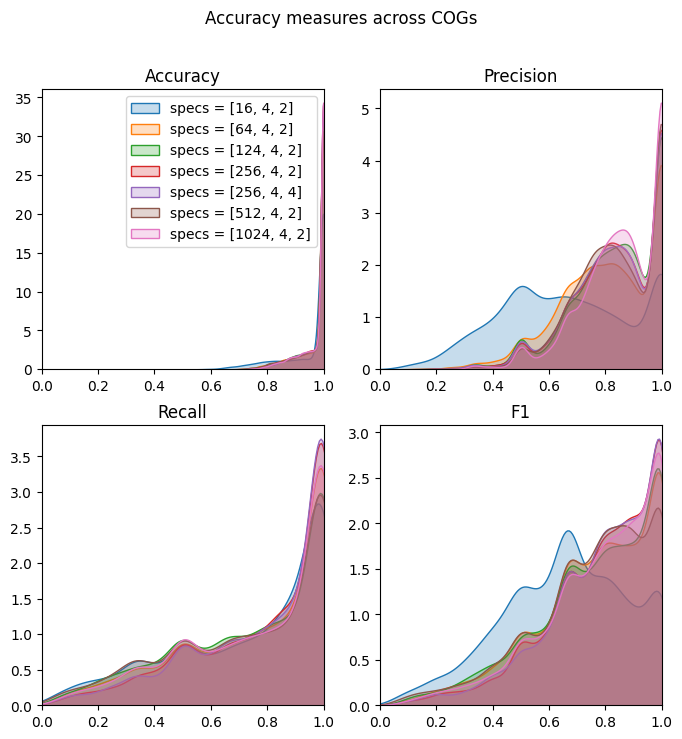

In [19]:
plt.figure(figsize=(8, 8))

# First subplot
plt.subplot(2, 2, 1)
for idx, model_path in enumerate(loaded_models_with_predict.keys()):
    X_true = loaded_models_with_predict[model_path]["X_true"]
    X_predict = loaded_models_with_predict[model_path]["X_predict"]
    to_plot_distributions_per_sample, to_plot_distributions_per_cog = accuracy_stats_per_cog_per_sample(X_true, X_predict, cog_names)
    sns.kdeplot(to_plot_distributions_per_cog["accuracy"], fill=True, label = f"specs = {loaded_models_with_predict[model_path]["specs"]}")
plt.xlim([0,1])
plt.ylabel("")
plt.title("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
for idx, model_path in enumerate(loaded_models_with_predict.keys()):
    X_true = loaded_models_with_predict[model_path]["X_true"]
    X_predict = loaded_models_with_predict[model_path]["X_predict"]
    to_plot_distributions_per_sample, to_plot_distributions_per_cog = accuracy_stats_per_cog_per_sample(X_true, X_predict, cog_names)
    sns.kdeplot(to_plot_distributions_per_cog["precision"], fill=True)
plt.title("Precision")
plt.xlim([0,1])
plt.ylabel("")

plt.subplot(2, 2, 3)
for idx, model_path in enumerate(loaded_models_with_predict.keys()):
    X_true = loaded_models_with_predict[model_path]["X_true"]
    X_predict = loaded_models_with_predict[model_path]["X_predict"]
    to_plot_distributions_per_sample, to_plot_distributions_per_cog = accuracy_stats_per_cog_per_sample(X_true, X_predict, cog_names)
    sns.kdeplot(to_plot_distributions_per_cog["recall"], fill=True)
plt.title("Recall")
plt.xlim([0,1])
plt.ylabel("")

plt.subplot(2, 2, 4)
for idx, model_path in enumerate(loaded_models_with_predict.keys()):
    X_true = loaded_models_with_predict[model_path]["X_true"]
    X_predict = loaded_models_with_predict[model_path]["X_predict"]
    to_plot_distributions_per_sample, to_plot_distributions_per_cog = accuracy_stats_per_cog_per_sample(X_true, X_predict, cog_names)
    sns.kdeplot(to_plot_distributions_per_cog["f1"], fill=True)
plt.title("F1")
plt.xlim([0,1])
plt.ylabel("")

plt.suptitle("Accuracy measures across COGs")

In [ ]:
# N = 10
# top_missclass(misclassified_cogs_fp, num_samples_processed, f"Top {N} FP Misclassified COGs:", N)
# print()
# top_missclass(misclassified_cogs_fn, num_samples_processed, f"Top {N} FN Misclassified COGs:", N)

Overall Metrics: accuracy = 0.97, precision = 0.83, recall = 0.88, f1 = 0.85


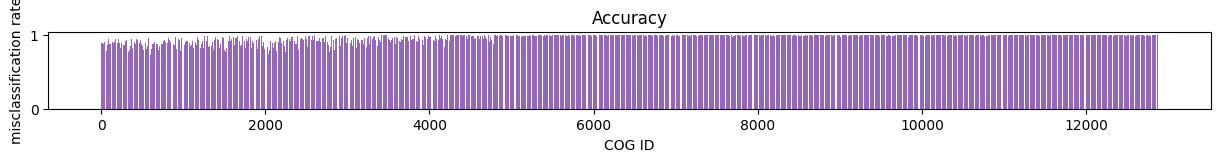

Overall Metrics: accuracy = 0.97, precision = 0.84, recall = 0.86, f1 = 0.85


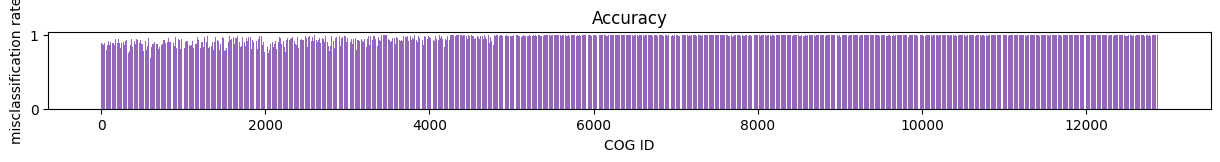

In [72]:
#for idx, model_path in enumerate(loaded_models_with_predict.keys()):
model_path = st_path_array[1]
X_true = loaded_models_with_predict[model_path]["X_true"]
X_predict = loaded_models_with_predict[model_path]["X_predict"]
to_plot_distributions_per_sample, to_plot_distributions_per_cog = accuracy_stats_per_cog_per_sample(X_true, X_predict, cog_names)
plot_misclassification_histogram(to_plot_distributions_per_cog["accuracy"], 'Accuracy', 'tab:purple', 'COG ID')

model_path = st_path_array[-1]
X_true = loaded_models_with_predict[model_path]["X_true"]
X_predict = loaded_models_with_predict[model_path]["X_predict"]
to_plot_distributions_per_sample, to_plot_distributions_per_cog = accuracy_stats_per_cog_per_sample(X_true, X_predict, cog_names)
plot_misclassification_histogram(to_plot_distributions_per_cog["accuracy"], 'Accuracy', 'tab:purple', 'COG ID')


Processing Batches: 100%|██████████| 50/50 [00:07<00:00,  7.06it/s]


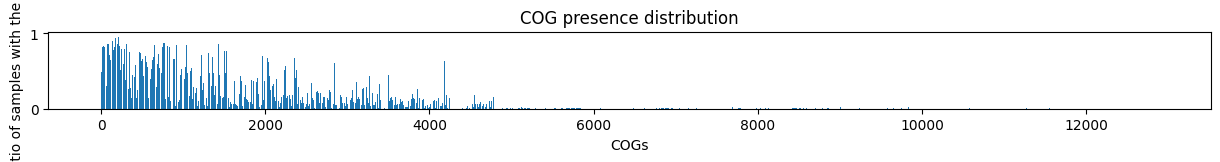

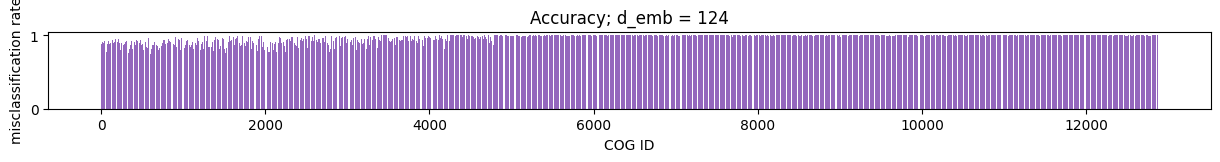

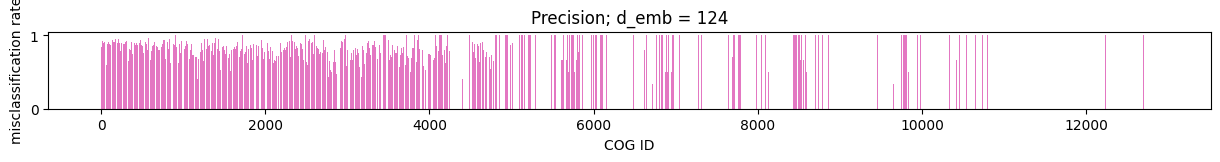

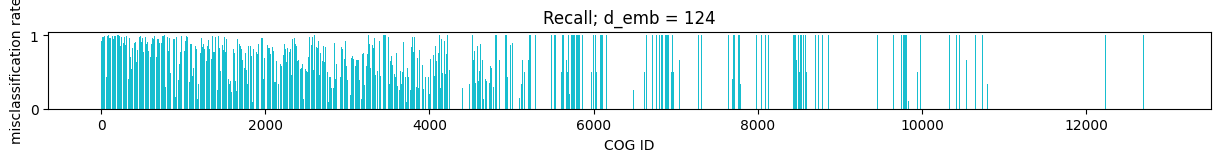

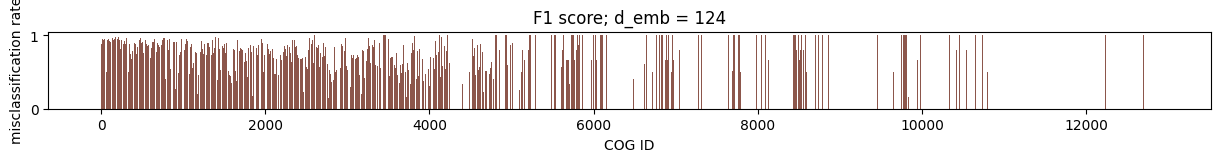

Processing Batches: 100%|██████████| 50/50 [00:07<00:00,  6.84it/s]


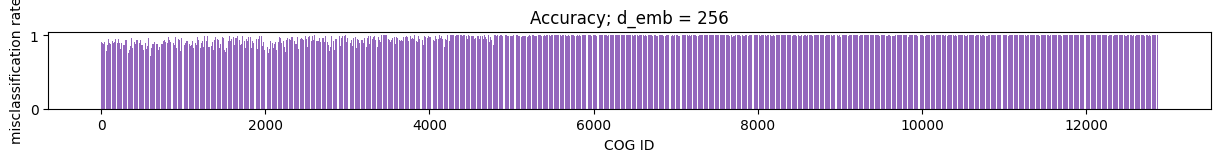

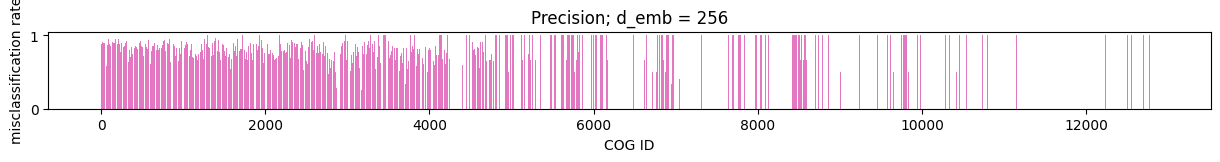

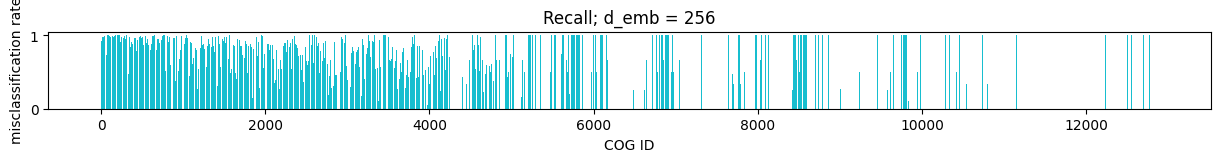

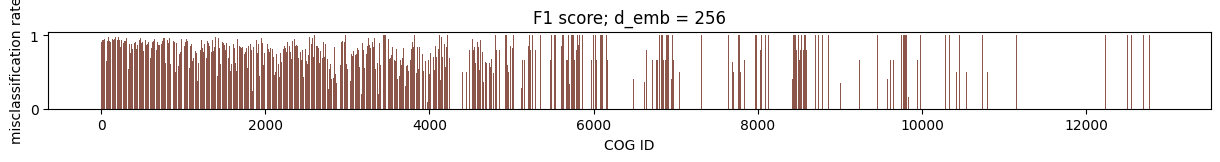

Processing Batches: 100%|██████████| 50/50 [00:07<00:00,  6.84it/s]


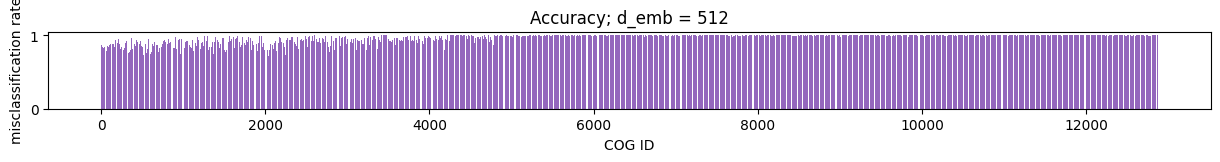

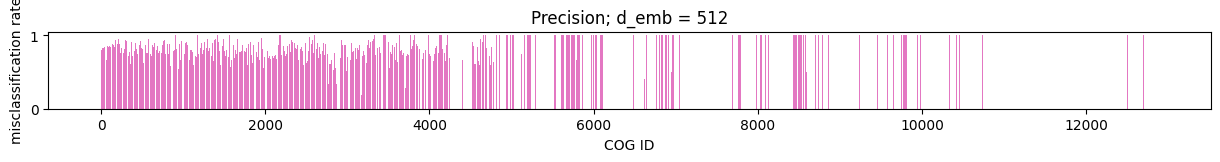

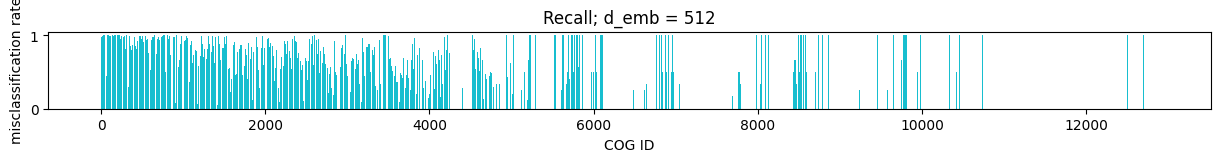

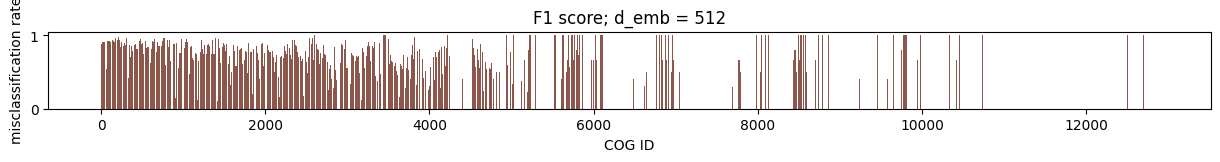

Processing Batches: 100%|██████████| 50/50 [00:08<00:00,  5.62it/s]


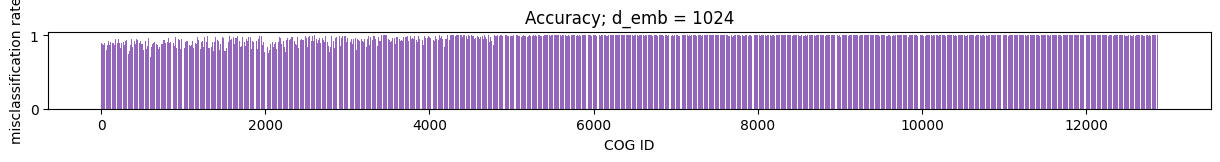

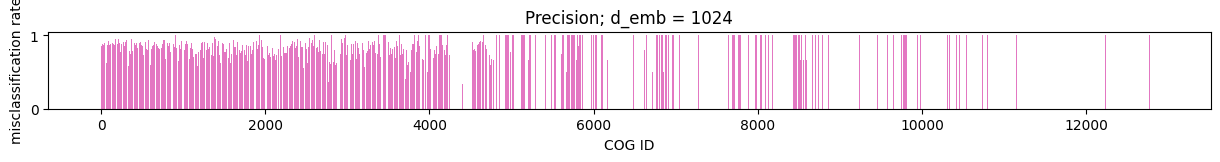

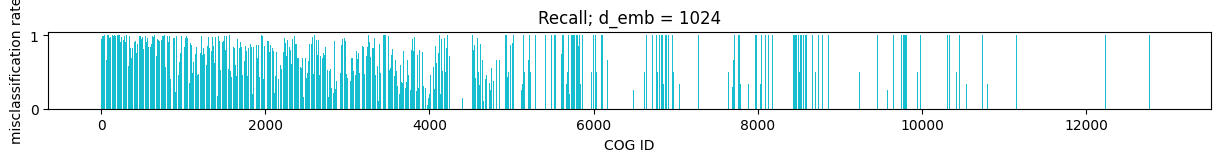

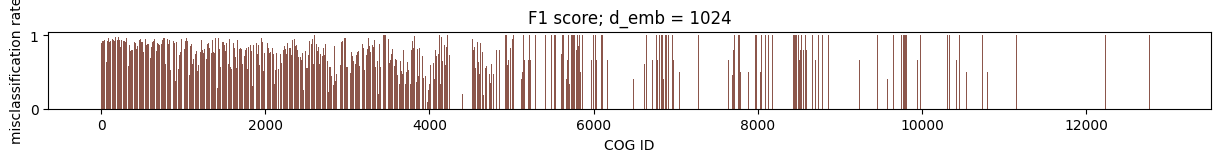

In [73]:
from post_train_process_utils import misclassif_metrics_per_posit, find_miscalssif_cogs, top_missclass


plt.figure(figsize=(15, 1))
df = pd.DataFrame(train_values)
df_binary = df.gt(0).astype(int)
column_sums = df_binary.sum().values
plt.bar(range(len(column_sums)), [c/len(sample_names) for c in column_sums], color='tab:blue')
plt.xlabel("COGs")
plt.ylabel("ratio of samples with the COG")
#plt.yscale("log")
plt.title("COG presence distribution")    

for idx, model_name in enumerate(loaded_models_with_predict.keys()):
    set_transformer = loaded_models_with_predict[model_name]["model"]
    misclassified_cogs_fp, misclassified_cogs_fn, correct_cogs_tp, correct_cogs_tn, num_samples_processed = find_miscalssif_cogs(set_transformer, train_loader, cog_names, DEVICE)
    fp_rate, fn_rate, tp_rate, tn_rate, accurac_per_cog, precis_per_cog, recall_per_cog, f1_score_per_cog = misclassif_metrics_per_posit(misclassified_cogs_fp, misclassified_cogs_fn, correct_cogs_tp, correct_cogs_tn, num_samples_processed)
    # plot_misclassification_histogram(fn_rate, 'False Negatives', 'tab:green', 'COG ID')
    # plot_misclassification_histogram(fp_rate, 'False Positives', 'tab:orange', 'COG ID')
    # plot_misclassification_histogram(tp_rate, 'True Positives', 'tab:red', 'COG ID')
    # plot_misclassification_histogram(tn_rate, 'True Negatives', 'tab:blue', 'COG ID')
    plot_misclassification_histogram(accurac_per_cog, f'Accuracy; d_emb = {embedd_dim[idx]}', 'tab:purple', 'COG ID')
    plot_misclassification_histogram(precis_per_cog, f'Precision; d_emb = {embedd_dim[idx]}', 'tab:pink', 'COG ID')
    plot_misclassification_histogram(recall_per_cog, f'Recall; d_emb = {embedd_dim[idx]}', 'tab:cyan', 'COG ID')
    plot_misclassification_histogram(f1_score_per_cog, f'F1 score; d_emb = {embedd_dim[idx]}', 'tab:brown', 'COG ID')

### 2. Sample space

#### 2.1 tSNE space of the samples in the origial train dataset

In [ ]:
tsne_bin = TSNE(n_components=2, random_state=4, perplexity=50, learning_rate=100, max_iter=5000)
train_samples = tsne_bin.fit_transform(train_values)

In [30]:
taxa_level = "class"  #'domain', 'phylum', 'class', 'order', 'family', 'group', 'species'
taxa_labels = train_df[taxa_level]
print(f"Found {len(np.unique(taxa_labels))} unique groups at {taxa_level} level for {len(taxa_labels)} samples")

Found 546 unique groups at class level for 90445 samples


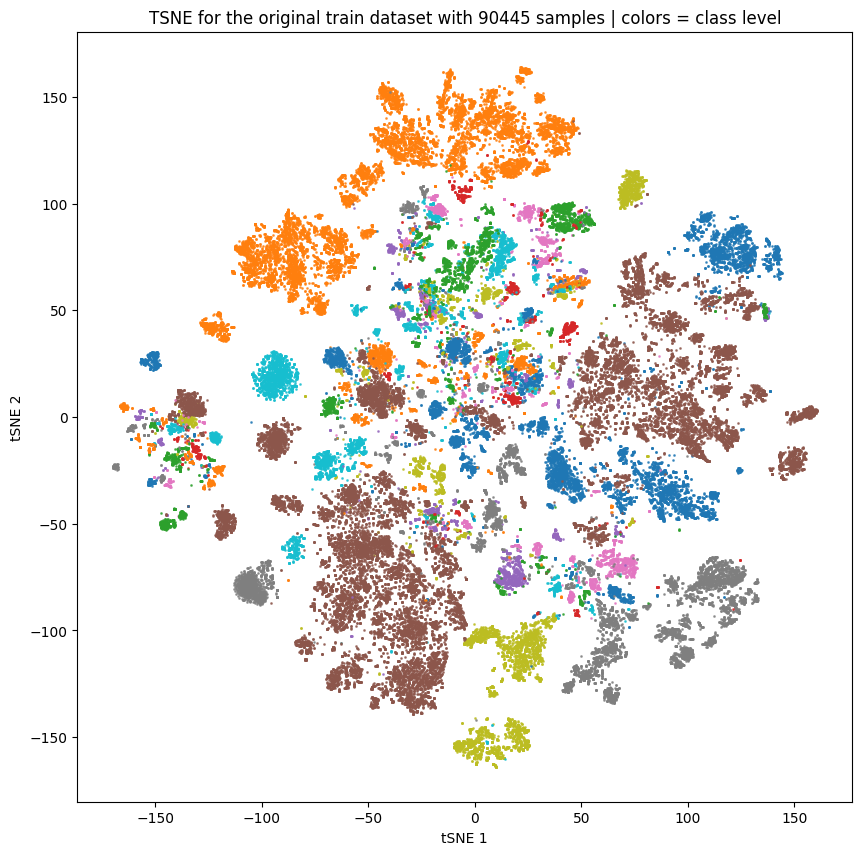

In [55]:
import seaborn as sns
unique_labels = np.unique(taxa_labels)
#palette = sns.color_palette("husl", len(unique_labels))  # "husl" can handle many categories
palette = sns.color_palette("tab10", len(unique_labels))  # Get distinct colors
color_map = {label: color for label, color in zip(unique_labels, palette)}

plt.figure(figsize=(10, 10))
for label in unique_labels:
    mask = taxa_labels == label  # Filter points for the specific label
    plt.scatter(train_samples[:, 0][mask], train_samples[:, 1][mask], color=color_map[label], label=label, s=1, alpha=0.7)

#plt.legend(title="Labels", markerscale=3, loc="upper right")
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.title(f"TSNE for the original train dataset with {len(sample_names)} samples | colors = {taxa_level} level")
plt.show()

### 3. Feature space

#### 3.1. Download a table of COG annotations

In [168]:
from post_train_process_utils import create_cogs_with_functions_df

functional_df = create_cogs_with_functions_df()

Downloaded cog-20.def.tab successfully.
First few rows of functional_df with Meta_Category:


#### 3.2. Pre-training feature set

In [70]:
# Merge the train COGs with their annotations
df_cogs = pd.DataFrame(train_values.T)

# Add the list of strings as the first column
df_cogs.insert(0, 'COG_ID', cog_names)
df_cogs = df_cogs.merge(functional_df[["COG_ID", "Category", "Meta_Category"]], on="COG_ID", how="left") 

# Replace Nan values by "no_label"
df_cogs['Meta_Category'] = df_cogs['Meta_Category'].fillna('no_label')
df_cogs = df_cogs.dropna(subset=["Meta_Category"])
df_cogs_val = df_cogs.iloc[:, 1:-2].values
print(f"df_cogs_val shape = {df_cogs_val.shape}")

df_cogs_val shape = (12873, 90445)


In [ ]:
tsne_bin = TSNE(n_components=2, random_state=4, perplexity=10, learning_rate=5, max_iter=2000)
pretrain_features_tsne = tsne_bin.fit_transform(df_cogs_val)

#### 3.3. Post-training feature embedding weights

In [71]:
from post_train_process_utils import load_model

# Load a trained model
st_path = 'full_set_transf_embedd_124_heads_4_sab_2_BCE.pth'
set_transformer = load_model(st_path, global_vocab, DEVICE)

# Extract only the COG identity embeddings (ignoring any additional count processing)
vocab_size = set_transformer.vocab_size 
cog_identity_embeddings = set_transformer.cog_embedding.weight[:vocab_size].detach().cpu().numpy()
print("COG identity embeddings shape:", cog_identity_embeddings.shape)

df_cog_embedd = pd.DataFrame(cog_identity_embeddings)
df_cog_embedd["COG_Index"] = np.arange(vocab_size)
df_cog_embedd = df_cog_embedd.merge(functional_df[["COG_Index", "Category", "Meta_Category"]], on="COG_Index", how="left")
df_cog_embedd['Meta_Category'] = df_cog_embedd['Meta_Category'].fillna('no_label')
df_cog_embedd = df_cog_embedd.dropna(subset=["Meta_Category"])

df_cog_embedd_val = df_cog_embedd.iloc[:, :-3].values
print("COG identity embeddings shape (values):", df_cog_embedd_val.shape)

COG identity embeddings shape: (12873, 124)
COG identity embeddings shape (values): (12873, 124)


In [7]:
tsne_bin = TSNE(n_components=2, random_state=4, perplexity=30, learning_rate=100, max_iter=3000)
embedd_weights_tsne = tsne_bin.fit_transform(df_cog_embedd_val)
embedd_weights_tsne.shape

NameError: name 'df_cog_embedd_val' is not defined

#### 3.4. Randomly generated initial feature weights

In [43]:
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

vocab_size = len(global_vocab)  
embedding_dim = df_cog_embedd_val.shape[1]  
embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=vocab_size-1)

# Apply Xavier initialization to the weights (same as in the model)
nn.init.xavier_uniform_(embedding_layer.weight)

# Extract the randomly initialized embedding weights
pre_training_rand_embeddings = embedding_layer.weight.data.clone()
pre_training_rand_embeddings_np = pre_training_rand_embeddings.numpy()
pre_training_rand_embeddings.shape

torch.Size([12873, 124])

In [44]:
tsne_bin = TSNE(n_components=2, random_state=4, perplexity=30, learning_rate=100, max_iter=3000)
pre_train_rand_tsne = tsne_bin.fit_transform(pre_training_rand_embeddings_np)
pre_train_rand_tsne.shape

(12873, 2)

#### 3.5. Hot-encoded features

In [45]:
one_hot_encoding = np.eye(vocab_size)  # One-hot for each COG_ID
one_hot_encoding.shape

(12873, 12873)

In [46]:
tsne_bin = TSNE(n_components=2, random_state=4, perplexity=30, learning_rate=100, max_iter=3000)
one_hot_encod_tsne = tsne_bin.fit_transform(one_hot_encoding)
one_hot_encod_tsne.shape

(12873, 2)

#### 3.6. Visualization of the feature tSNE projections

In [47]:
import seaborn as sns
# Color map for the COG categories
category_names = df_cogs["Meta_Category"]
unique_labels = np.unique(category_names)
palette = sns.color_palette("tab10", len(unique_labels))  
color_map = {label: color for label, color in zip(unique_labels, palette)}


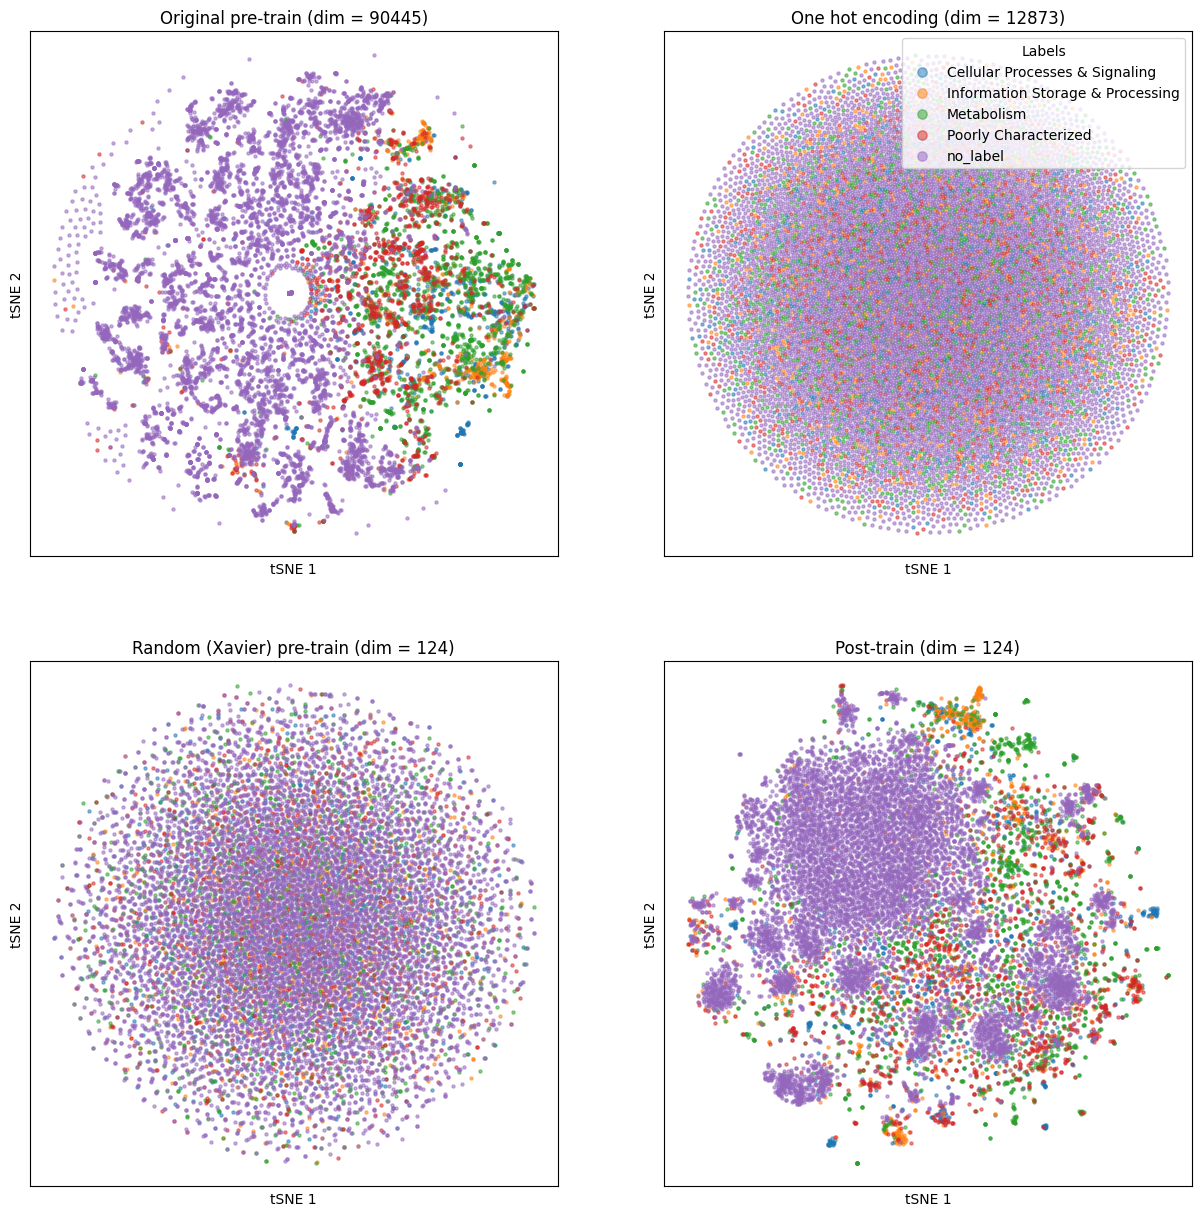

In [60]:
plt.figure(figsize=(15, 15))

# 1: Original pre-training tSNE feature projection
plt.subplot(2, 2, 1)

for label in unique_labels:
    mask = category_names == label  # Filter points for the specific label
    plt.scatter(pretrain_features_tsne[:, 0][mask], pretrain_features_tsne[:, 1][mask], color=color_map[label], label=label, s=5, alpha=0.5)

#plt.legend(title="Labels", markerscale=3, loc="upper right")
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.title(f"Original pre-train (dim = {df_cogs_val.shape[1]})")
plt.xticks([])
plt.yticks([])

# 2: One hot-encoded feature space
plt.subplot(2, 2, 2)

for label in unique_labels:
    mask = category_names == label  # Filter points for the specific label
    plt.scatter(one_hot_encod_tsne[:, 0][mask], one_hot_encod_tsne[:, 1][mask], color=color_map[label], label=label, s=5, alpha=0.5)

plt.legend(title="Labels", markerscale=3, loc="upper right")
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.title(f"One hot encoding (dim = {one_hot_encoding.shape[1]})")
plt.xticks([])
plt.yticks([])

# 3: Randomly generated with Xavier initialization features
plt.subplot(2, 2, 3)

for label in unique_labels:
    mask = category_names == label  # Filter points for the specific label
    plt.scatter(pre_train_rand_tsne[:, 0][mask], pre_train_rand_tsne[:, 1][mask], color=color_map[label], label=label, s=5, alpha=0.5)

#plt.legend(title="Labels", markerscale=3, loc="upper right")
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.title(f"Random (Xavier) pre-train (dim = {pre_training_rand_embeddings.shape[1]})")
plt.xticks([])
plt.yticks([])

# 4: Post-training feature embeddings
plt.subplot(2, 2, 4)

for label in unique_labels:
    mask = category_names == label  # Filter points for the specific label
    plt.scatter(embedd_weights_tsne[:, 0][mask], embedd_weights_tsne[:, 1][mask], color=color_map[label], label=label, s=5, alpha=0.5)

#plt.legend(title="Labels", markerscale=3, loc="upper right")
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.title(f"Post-train (dim = {df_cog_embedd_val.shape[1]})")
plt.grid("True")
plt.xticks([])
plt.yticks([])

#plt.suptitle("COG Embeddings Comparison", fontsize=16)

plt.show()

### 4. Visualize the trained model intermediate projections

#### 4.1 Visualize the attention scores

In [98]:
i=0
st_path = st_path_array[i]
d_model = embedd_dim[i]
set_transformer = load_model(st_path, global_vocab, DEVICE, d_model, num_heads=4, num_sab=2) 

In [99]:
from tqdm import tqdm

# Functions for creating the hooks
def capture_attention_weights(module, input, output):
    global attention_weights
    attention_weights = output[1].to(DEVICE)  # The second element is the attention weights

def register_last_sab_attent_scores_hooks(model):
    last_sab_block = model.sab_blocks[-1]
    last_sab_block.mha.register_forward_hook(capture_attention_weights)

# Create last sab mha hook
register_last_sab_attent_scores_hooks(set_transformer)

# Initialize the matrix of attention scores
attention_scores_mtr = torch.zeros(pad_idx, pad_idx, device=DEVICE)# np.zeros((pad_idx, pad_idx), dtype=object) # [[(0,0) for _ in range(pad_idx)] for _ in range(pad_idx)]
attention_counts_mtr = torch.zeros(pad_idx, pad_idx, device=DEVICE)  # Matrix to track how often each pair is attended

train_loader = generate_noisy_dataset(train_df, global_vocab, batch_size, pad_idx, fn_rate=0, fp_rate=0)

set_transformer.eval()
set_transformer.to(DEVICE)
with torch.no_grad():
    for tokens, mask, targets in tqdm(train_loader, desc="Processing Batches"):
       # count += 1
        tokens = tokens.to(DEVICE)
        mask = mask.to(DEVICE)
        
        preds = set_transformer(tokens, mask)

        batch_size = tokens.shape[0]
        seq_len = tokens.shape[1]

        # Convert tokens to indices (COG IDs)
        cog_ids = tokens[:, :, 0].long()  # (batch_size, seq_len)
        token_counts = tokens[:, :, 1]    # (batch_size, seq_len)

        for sample_id in range(len(cog_ids)):
            present_tokens_mask = token_counts[sample_id] > 0
            present_cogs_ids = cog_ids[sample_id][present_tokens_mask]

            # for i, row_cog_id in enumerate(present_cogs_ids):
            #    # print(f"i = {i}; row_cog_id = {row_cog_id}")
            #     values = attention_weights[sample_id][i][present_tokens_mask]
            #     attention_scores_mtr[row_cog_id, present_cogs_ids]  += values
            #     attention_counts_mtr[row_cog_id, present_cogs_ids] += 1



Processing Batches:   3%|▎         | 227/9045 [00:31<20:29,  7.17it/s]


KeyboardInterrupt: 

tensor([[5.2731e-05, 9.2944e-08, 2.4831e-06,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.4322e-07, 1.7823e-06, 9.3258e-07,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0629e-04, 1.6010e-06, 1.5745e-05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [3.7405e-04, 2.4150e-05, 2.9403e-06,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.7405e-04, 2.4150e-05, 2.9403e-06,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.7405e-04, 2.4150e-05, 2.9403e-06,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], device='cuda:0')


<Axes: >

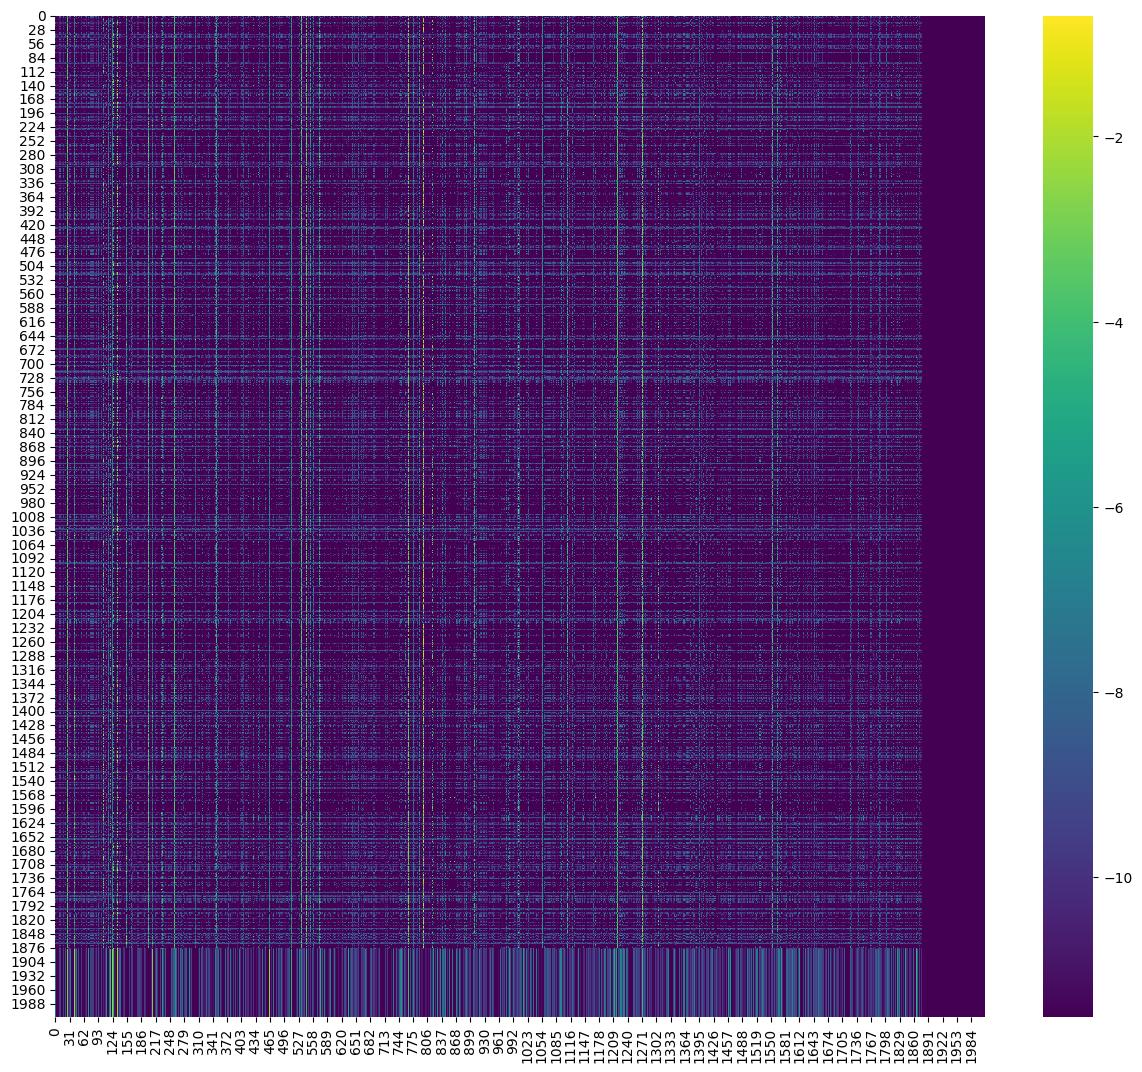

In [102]:
import seaborn as sns
i=5
print(attention_weights[i])
to_plot_log = torch.log(torch.clamp(attention_weights[i], min=1e-5)).cpu().numpy()



#torch.log(torch.clamp(attention_weights[0].cpu().numpy(), min=1e-5))


plt.figure(figsize=(15, 13))
sns.heatmap(to_plot_log, cmap='viridis', cbar=True)

In [97]:
to_plot = attention_weights[i]
to_plot
# sum(to_plot[110])

tensor([[0.0010, 0.0008, 0.0007,  ..., 0.0000, 0.0000, 0.0000],
        [0.0009, 0.0008, 0.0008,  ..., 0.0000, 0.0000, 0.0000],
        [0.0009, 0.0009, 0.0007,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0010, 0.0009, 0.0007,  ..., 0.0000, 0.0000, 0.0000],
        [0.0010, 0.0009, 0.0007,  ..., 0.0000, 0.0000, 0.0000],
        [0.0010, 0.0009, 0.0007,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [42]:
average_attention_scores_mtr = attention_scores_mtr / (attention_counts_mtr + 1e-9)
average_attention_scores_mtr_log = torch.log(torch.clamp(average_attention_scores_mtr, min=1e-5))
average_attention_scores_mtr_log.shape
average_attention_scores_mtr_log

tensor([[ -8.0501,  -7.2318,  -8.2473,  ...,  -6.4942,  -8.2291,  -9.6194],
        [ -8.6448,  -6.4685,  -7.2215,  ...,  -7.7563,  -7.3638,  -7.9661],
        [ -8.3333,  -8.2946,  -6.4472,  ...,  -5.5998,  -8.5520, -11.5129],
        ...,
        [ -7.7992,  -5.4988,  -5.6124,  ...,  -6.6124, -11.5129, -11.5129],
        [-11.5129,  -8.3701, -11.5129,  ..., -11.5129,  -7.7571, -11.5129],
        [ -8.5166,  -9.6793, -11.5129,  ..., -11.5129, -11.5129,  -7.9178]],
       device='cuda:0')

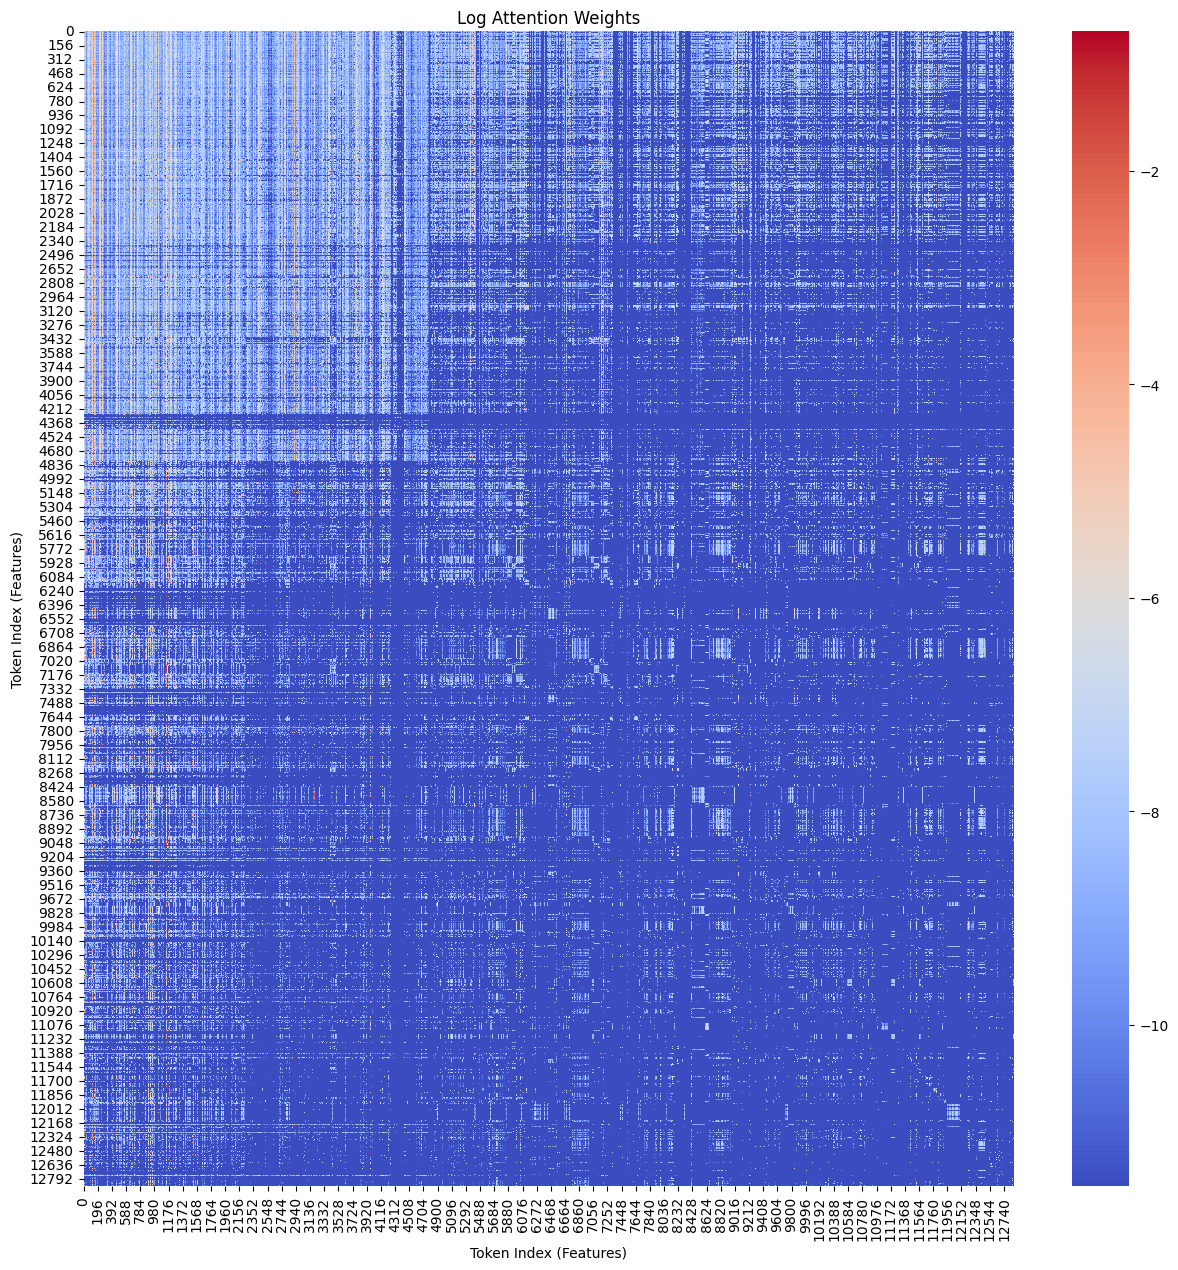

In [43]:
import seaborn as sns
plt.figure(figsize=(15, 15))
sns.heatmap(average_attention_scores_mtr_log.cpu().numpy(), cmap='coolwarm', cbar=True)
plt.title(f"Log Attention Weights")
plt.xlabel("Token Index (Features)")
plt.ylabel("Token Index (Features)")
plt.show()

In [13]:
# Sorting COG indices wrt the function

global_vocab_pd = pd.DataFrame(global_vocab, columns=["COG_ID"])
merged_df = pd.merge(global_vocab_pd, functional_df, on='COG_ID', how='left')

# Fill missing values in 'value2' with 'no_label'
merged_df['Meta_Category'] = merged_df['Meta_Category'].fillna('no_label')
merged_df['COG_Index'] = merged_df.index

uniq_categ = np.unique(merged_df['Meta_Category'])
print(uniq_categ)

# Sort the DataFrame by the 'Group' column first, and then by 'COG_Index'
merged_df = merged_df.sort_values(by=['Meta_Category', 'COG_Index'], ascending=[True, True])
sorting_ind = merged_df['COG_Index']
merged_df


['Cellular Processes & Signaling' 'Information Storage & Processing'
 'Metabolism' 'Poorly Characterized' 'no_label']


COG_ID Category                   Meta_Category  COG_Index
66        COG0068        O  Cellular Processes & Signaling         66
69        COG0071        O  Cellular Processes & Signaling         69
82        COG0084        N  Cellular Processes & Signaling         82
168       COG0170       OM  Cellular Processes & Signaling        168
199       COG0201        U  Cellular Processes & Signaling        199
...           ...      ...                             ...        ...
12868  arCOG15264      NaN                        no_label      12868
12869  arCOG15268      NaN                        no_label      12869
12870  arCOG15271      NaN                        no_label      12870
12871  arCOG15273      NaN                        no_label      12871
12872  arCOG15274      NaN                        no_label      12872

[12873 rows x 4 columns]

In [14]:
grouped_indices = merged_df.groupby('Meta_Category').apply(lambda group: group.index.tolist())
category_lengths = grouped_indices.apply(len)
category_lengths

/scratch/ipykernel_3238111/4141767906.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_indices = merged_df.groupby('Meta_Category').apply(lambda group: group.index.tolist())


Meta_Category
Cellular Processes & Signaling       938
Information Storage & Processing     712
Metabolism                          1568
Poorly Characterized                1252
no_label                            8403
dtype: int64

In [46]:
shuffled_attn_matrix_log = torch.log(torch.clamp(average_attention_scores_mtr[sorting_ind, :][:, sorting_ind], min=1e-5))

#shuffled_attn_matrix = attention_scores_mtr[sorting_ind, :][:, sorting_ind]
shuffled_attn_matrix_log

tensor([[ -6.5163,  -7.4740,  -7.5064,  ...,  -9.3289,  -7.6857,  -7.7067],
        [ -8.9021,  -4.8874,  -6.9151,  ..., -11.5129,  -8.3301, -11.5129],
        [ -8.1502,  -6.0745,  -5.6643,  ...,  -9.7110, -11.5129, -11.5129],
        ...,
        [ -6.9534,  -8.5750,  -8.1700,  ...,  -6.6124, -11.5129, -11.5129],
        [ -7.5335, -10.2249, -11.5129,  ..., -11.5129,  -7.7571, -11.5129],
        [ -8.3303,  -7.5320, -11.5129,  ..., -11.5129, -11.5129,  -7.9178]],
       device='cuda:0')

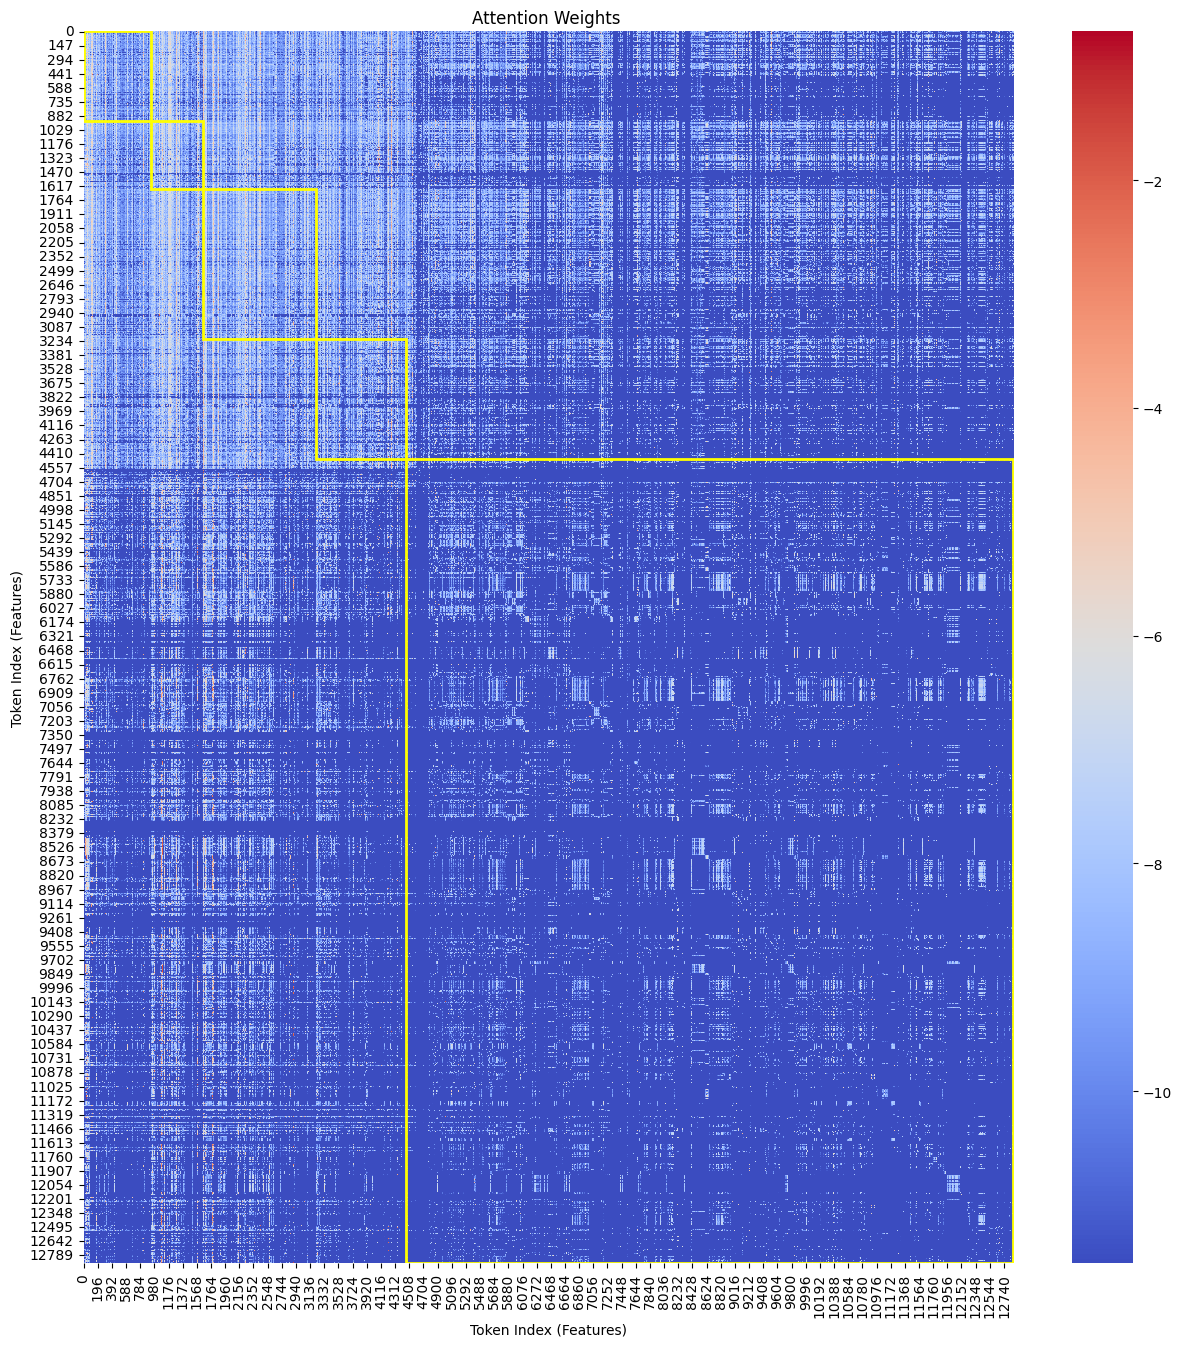

In [47]:
import seaborn as sns
from matplotlib.patches import Rectangle

category_names = df_cogs["Meta_Category"]
unique_labels = np.unique(category_names)
#palette = sns.color_palette("husl", len(unique_labels))  # "husl" can handle many categories
palette = sns.color_palette("tab10", len(unique_labels))  
color_map = {label: color for label, color in zip(unique_labels, palette)}

blocks = [
    (0, 937, 0, 937),
    (937, 937+712, 937, 937+712),
    (937+712, 937+712+1568, 937+712, 937+712+1568),
    (937+712+1568, 937+712+1568+1252, 937+712+1568, 937+712+1568+1252),
    (937+712+1568+1252, 937+712+1568+1252+8403, 937+712+1568+1252, 937+712+1568+1252+8403)
]
category_names = df_cogs["Meta_Category"]
unique_labels = np.unique(category_names)
#palette = sns.color_palette("husl", len(unique_labels))  # "husl" can handle many categories
palette = sns.color_palette("tab10", len(unique_labels))  
color_map = {label: color for label, color in zip(unique_labels, palette)}

plt.figure(figsize=(15, 16))
ax = sns.heatmap(shuffled_attn_matrix_log.cpu().numpy(), cmap='coolwarm', cbar=True) #[:4500, :4500]
counter = 0
for (x_start, x_end, y_start, y_end) in blocks:
    label = unique_labels[counter]
    rect = Rectangle((x_start, y_start), x_end - x_start, y_end - y_start,
                     linewidth=2, edgecolor="yellow", facecolor='none')
    counter += 1
    ax.add_patch(rect)

plt.title(f"Attention Weights ")
plt.xlabel("Token Index (Features)")
plt.ylabel("Token Index (Features)")
plt.show()

#### 4.2 Visualize the output of the PMA layer

In [6]:
import torch
from torch.utils.data import  DataLoader
from data_processing_utils.data_processing_functions import GenomeDataset, collate_genomes

def generate_noisy_dataset(df, global_vocab, batch_size, pad_idx, fn_rate, fp_rate, count_noise_std=0, random_state=42):
     dataset = GenomeDataset(df, global_vocab,
                               false_negative_rate=fn_rate, false_positive_rate=fp_rate,
                               count_noise_std=count_noise_std, random_state=random_state)
     dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda batch: collate_genomes(batch, pad_idx=pad_idx))   
     return dataset_loader

batch_size = 10
pad_idx = len(global_vocab) # padding size
train_loader = generate_noisy_dataset(train_df, global_vocab, batch_size, pad_idx, fn_rate=0, fp_rate=0)


pma_outputs = []

def hook_fn(module, input, output):
    global pma_outputs
    output = output.squeeze(0) 
    pma_outputs += list(output.detach().cpu().numpy())

def register_hooks(model):
    model.pma.ln.register_forward_hook(hook_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_transformer = load_model(st_path, global_vocab, DEVICE)
set_transformer.to(device)
register_hooks(set_transformer)

In [7]:
#~20m
set_transformer.eval()
count = 0
with torch.no_grad():
    for tokens, mask, targets in train_loader:
        count += 1
        tokens = tokens.to(device)
        mask = mask.to(device)
        preds = set_transformer(tokens, mask)

In [8]:
train_values.shape
#pma_outputs.shape
pma_outputs = np.array(pma_outputs)
pma_outputs.shape

(90445, 124)

In [9]:
tsne_bin = TSNE(n_components=2, random_state=4, perplexity=50, learning_rate=100, max_iter=5000)
pma_outputs_tsne = tsne_bin.fit_transform(pma_outputs)

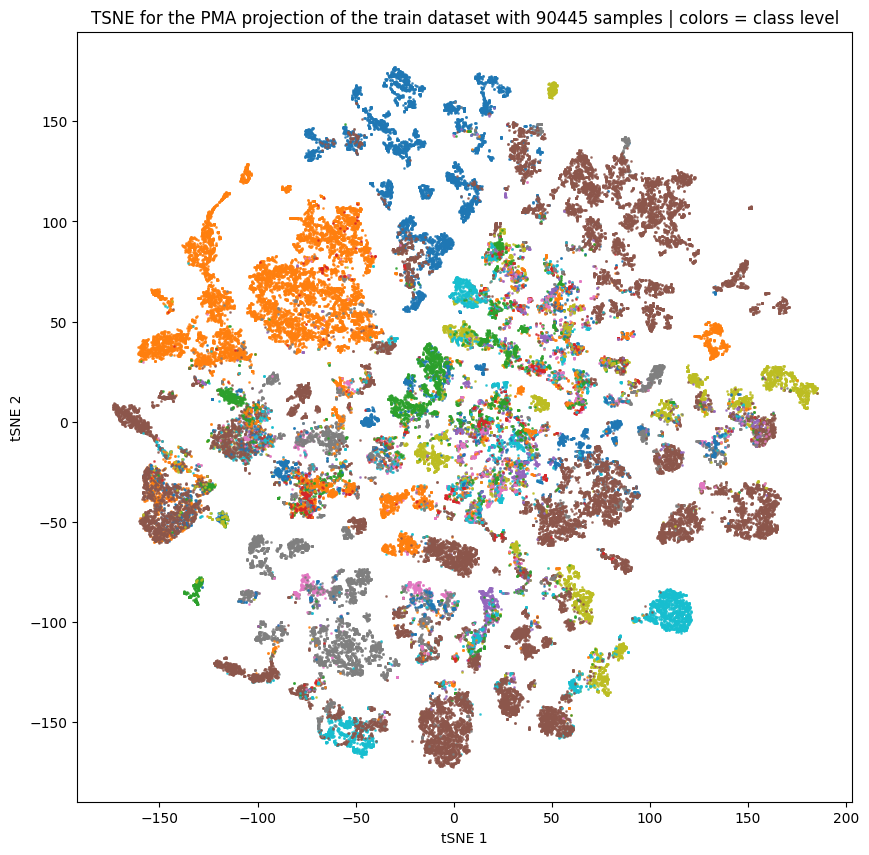

In [ ]:

taxa_level = "class"  #'domain', 'phylum', 'class', 'order', 'family', 'group', 'species'
taxa_labels = train_df[taxa_level]
unique_labels = np.unique(taxa_labels)
#palette = sns.color_palette("husl", len(unique_labels))  # "husl" can handle many categories
palette = sns.color_palette("tab10", len(unique_labels))  # Get distinct colors
color_map = {label: color for label, color in zip(unique_labels, palette)}

plt.figure(figsize=(10, 10))
for label in unique_labels:
    mask = taxa_labels == label  # Filter points for the specific label
    plt.scatter(pma_outputs_tsne[:, 0][mask], pma_outputs_tsne[:, 1][mask], color=color_map[label], label=label, s=1, alpha=0.7)

#plt.legend(title="Labels", markerscale=3, loc="upper right")
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.title(f"TSNE for the PMA projection of the train dataset with {len(sample_names)} samples | colors = {taxa_level} level")
plt.show()

### 5. Misclassified COGs